In [1]:
# Imports

import numpy as np
import pandas as pd

from nltk import FreqDist
from nltk.corpus import stopwords
import spacy
import re
from collections import OrderedDict
import itertools
import string
import praw
from wordcloud import WordCloud, get_single_color_func
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 50

In [2]:
# 1000 top posts from washingtondc since as of 2/22/2024
df = pd.read_pickle('data/20240222_washingtondc_top_month_reddit_data.pkl')

In [3]:
df.head()

,submission,id,subreddit,title,url,selftext,is_self,post_hint,score,upvote_ratio,num_comments,comments,created_utc,datetime,date_retrieved,submission_age
0,1acoj5j,1acoj5j,washingtondc,I respect this from 2 Amys over by Cathedral H...,https://i.redd.it/1j0z07tbk2fc1.jpeg,"No tip line, and hospitality costs are baked i...",False,image,1593,0.98,125,"(kjvm5ac, kjvo2bd, kjvum07, kjvumye, kjws7m8, ...",1.706399e+09,2024-01-27 18:43:22,2024-02-22 12:57:58.077015,25 days 18:14:36.077015
1,1afzruw,1afzruw,washingtondc,DC FEMALES PLEASE WATCH OUT FOR THIS MAN!!,https://www.reddit.com/gallery/1afzruw,"Hi! I am a fourteen year old female. Today, I ...",False,None,1479,0.96,17,"(kodpifa, kodncn1, kodp8ee, kodrmql, kodq8yl, ...",1.706754e+09,2024-01-31 21:15:04,2024-02-22 12:57:58.077015,21 days 15:42:54.077015
2,19dyrkt,19dyrkt,washingtondc,My first Cyber Truck sighting in DC!,https://i.redd.it/u9ma5n2y69ec1.jpeg,"Kinda cool, but Musk is a tool…",False,image,1448,0.87,357,"(kj95wyw, kj9g23j, kj9vfpo, kj951kh, kj9gdqj, ...",1.706043e+09,2024-01-23 15:56:42,2024-02-22 12:57:58.077015,29 days 21:01:16.077015
3,1ajnjbk,1ajnjbk,washingtondc,"DC implements this, what do you do?",https://i.redd.it/3n3exbck7tgc1.png,I am up for it as it is the biggest contributo...,False,image,1268,0.94,270,"(kp272iz, kp27d42, kp25hso, kp24vjk, kp28570, ...",1.707157e+09,2024-02-05 13:24:10,2024-02-22 12:57:58.077015,16 days 23:33:48.077015
4,1akqac4,1akqac4,washingtondc,For the love of God can we cut this shit out?,https://i.redd.it/ge87fajpb2hc1.jpeg,Your dog belongs at HOME. And NOT in a grocery...,False,image,1020,0.76,655,"(kp9vbo7, kp9lwr7, kp9ld7r, kp9we5y, kp9lqzk, ...",1.707268e+09,2024-02-06 20:03:19,2024-02-22 12:57:58.077015,15 days 16:54:39.077015


In [4]:
subreddit = df.iloc[0]['subreddit']
date_retrieved = df.iloc[0]['date_retrieved']
oldest = dt.datetime.strftime(df['datetime'].min(), "%m/%d/%Y")
newest = dt.datetime.strftime(df['datetime'].max(), "%m/%d/%Y")
date_retrieved = dt.datetime.strftime(date_retrieved, "%m/%d/%Y")

## Change as necessary. Cosmetic changes only.
sort = 'top'
time_filter = '<N/A>' if sort=='new' else 'month'
##

print(subreddit)
print(sort)
print(time_filter)
print(date_retrieved)
print(oldest)
print(newest)

washingtondc
top
month
02/22/2024
01/23/2024
02/21/2024


In [5]:
df['title'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: title
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [6]:
df['selftext'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: selftext
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [7]:
df['datetime'].describe()

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\476314687.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['datetime'].describe()


count                    1000
unique                   1000
top       2024-01-27 18:43:22
freq                        1
first     2024-01-23 00:45:47
last      2024-02-21 21:50:00
Name: datetime, dtype: object

In [8]:
df_nlp = df[['id', 'title', 'selftext', 'datetime']]

In [9]:
# Combine the title and body of the post

df_nlp['text_comb'] = df_nlp['title'] + '. ' + df_nlp['selftext']

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\4121555173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb'] = df_nlp['title'] + '. ' + df_nlp['selftext']


In [10]:
def clean_string(text):
    
    # Make everything lowercase
    cleaned = text.lower()

    # Remove excessive white space and newlines
    cleaned = cleaned.replace("\n", " ")
    cleaned = re.sub(pattern=r' {2,}', repl=' ', string=cleaned)

    # Ensure apostrophes and quotation marks are consistent
    cleaned = re.sub(r"’|‘", repl="'", string=cleaned)
    cleaned = re.sub(r"“|”", repl='"', string=cleaned)

    # Remove any difficult characters like emojis, elipses, etc. 
    cleaned = ''.join(filter(lambda x: x in string.printable, cleaned))
    
    return cleaned

In [11]:
df_nlp['text_comb'] = df_nlp['text_comb'].apply(clean_string)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\1584605208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb'] = df_nlp['text_comb'].apply(clean_string)


Why not remove punctuation in the cleaning step?

Removing punctuation is a common step in cleaning text for NLP. I don't do it here since I plan to lemmatize words which requires keeping grammatical context in the text. Punctuation will be removed in a future step.

In [12]:
# Setting up Spacy

nlp = spacy.load('en_core_web_sm')

In [13]:
# Combine Spacy and NLTK stop words to make them more comperehensive

sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
punct = list(string.punctuation)
stopword_list = list(set(sw_spacy + sw_nltk + punct))

## text_comb column

In [14]:
df_nlp['text_comb'].isna().sum()

0

In [15]:
# Making a Spacy object for each title

df_nlp['spacy_text_comb'] = df_nlp['text_comb'].apply(lambda x: nlp(clean_string(x)))

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\3001191996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['spacy_text_comb'] = df_nlp['text_comb'].apply(lambda x: nlp(clean_string(x)))


In [16]:
# df_nlp.sample()['title']

In [17]:
df_nlp['text_comb'].loc[81]

"good on you 2amy's!. there's no tip line at all."

In [18]:
# How Spacy's nlp object works:

sample_title = df_nlp['text_comb'].loc[81]

display('Spacy Object:')
display(nlp(sample_title))
print('Type:')
print(type(nlp(sample_title)))
print()
print('Tokens:')
print([t.text for t in list(nlp(sample_title))])
print()
print('Lemmas:')
print([t.lemma_ for t in list(nlp(sample_title))])
print()
print('Detect punctuation, numbers, etc.:')
print([t.is_punct for t in list(nlp(sample_title))])
print([t.is_digit for t in list(nlp(sample_title))])

'Spacy Object:'

good on you 2amy's!. there's no tip line at all.

Type:
<class 'spacy.tokens.doc.Doc'>

Tokens:
['good', 'on', 'you', '2amy', "'s", '!', '.', 'there', "'s", 'no', 'tip', 'line', 'at', 'all', '.']

Lemmas:
['good', 'on', 'you', '2amy', "'s", '!', '.', 'there', 'be', 'no', 'tip', 'line', 'at', 'all', '.']

Detect punctuation, numbers, etc.:
[False, False, False, False, False, True, True, False, False, False, False, False, False, False, True]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [19]:
df_nlp.head()

,id,title,selftext,datetime,text_comb,spacy_text_comb
0,1acoj5j,I respect this from 2 Amys over by Cathedral H...,"No tip line, and hospitality costs are baked i...",2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,"(i, respect, this, from, 2, amys, over, by, ca..."
1,1afzruw,DC FEMALES PLEASE WATCH OUT FOR THIS MAN!!,"Hi! I am a fourteen year old female. Today, I ...",2024-01-31 21:15:04,dc females please watch out for this man!!. hi...,"(dc, females, please, watch, out, for, this, m..."
2,19dyrkt,My first Cyber Truck sighting in DC!,"Kinda cool, but Musk is a tool…",2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,"(my, first, cyber, truck, sighting, in, dc, !,..."
3,1ajnjbk,"DC implements this, what do you do?",I am up for it as it is the biggest contributo...,2024-02-05 13:24:10,"dc implements this, what do you do?. i am up f...","(dc, implements, this, ,, what, do, you, do, ?..."
4,1akqac4,For the love of God can we cut this shit out?,Your dog belongs at HOME. And NOT in a grocery...,2024-02-06 20:03:19,for the love of god can we cut this shit out?....,"(for, the, love, of, god, can, we, cut, this, ..."


### Tokenizing

In [20]:
def spacy_tokenize(spacy_doc):
    """
    Takes in a Spacy doc and converts it to a list of tokens.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    tokens = [t.text for t in spacy_doc if token_mask(t)]
    return tokens

In [21]:
df_nlp['text_comb_tokens'] = df_nlp['spacy_text_comb'].apply(spacy_tokenize)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\4008261418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_tokens'] = df_nlp['spacy_text_comb'].apply(spacy_tokenize)


C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\2218918524.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


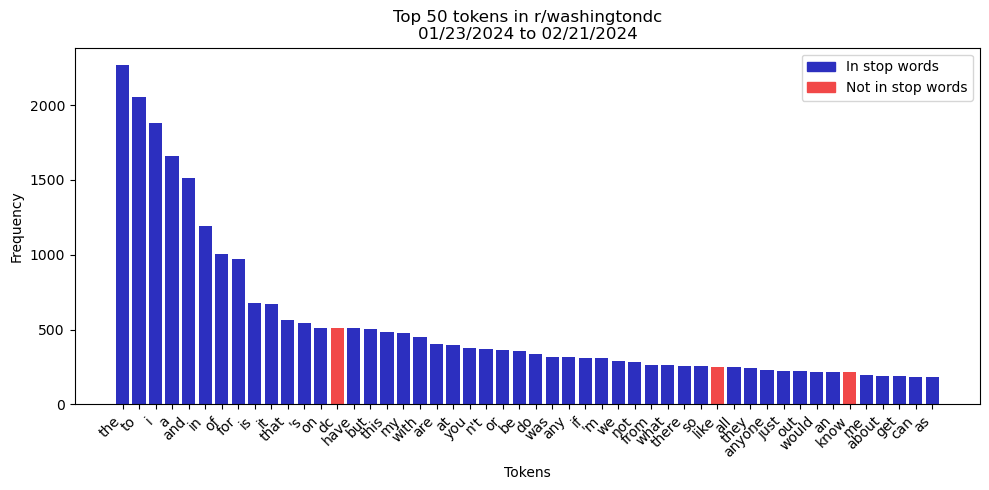

In [22]:
# Most frequent tokens. Stop words color-coded.

fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(df_nlp['text_comb_tokens'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
not_sw = [t for t in tokens if t not in stopword_list]
ax.bar(x=tokens, height=freq, color=['#f14848' if t in not_sw else '#2c2fbf' for t in tokens])
ax.set_ylabel('Frequency', size=10)
ax.set_xlabel('Tokens', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title(f'Top 50 tokens in r/{subreddit}\n{oldest} to {newest}')
custom_bars = [Rectangle((0,0),1,1,color=c, alpha=1) for c in ['#2c2fbf', '#f14848']]
ax.legend(custom_bars, ['In stop words','Not in stop words'], fontsize=10)
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_tokens2.png', dpi=500)
plt.show()

In [23]:
df_nlp['text_comb_tokens_no_sw'] = df_nlp['text_comb_tokens'].apply(lambda x: [t for t in x if t not in stopword_list])

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\797248638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_tokens_no_sw'] = df_nlp['text_comb_tokens'].apply(lambda x: [t for t in x if t not in stopword_list])


C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\4150107605.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


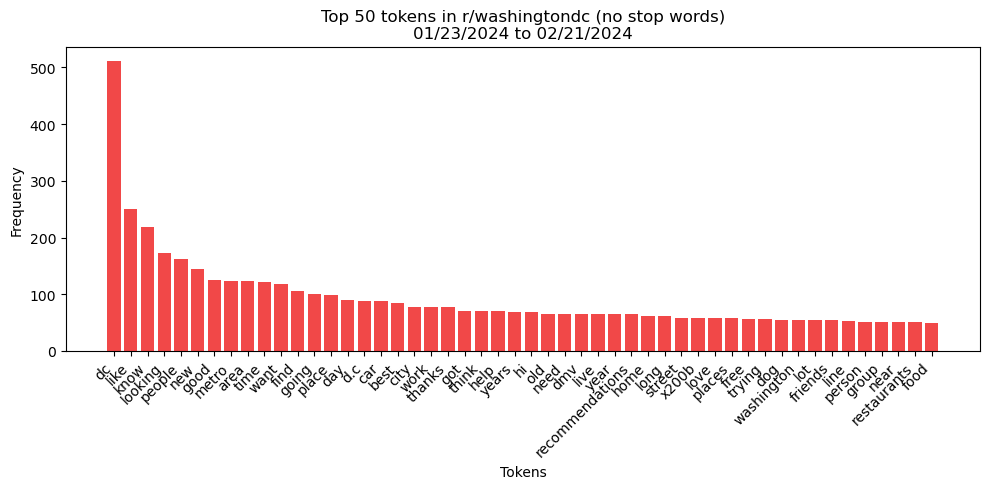

In [24]:
# Seeing most frequent tokens without stopwords:

fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(df_nlp[df_nlp['text_comb_tokens_no_sw'].apply(lambda x: len(x) > 0)]['text_comb_tokens_no_sw'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
ax.bar(x=tokens, height=freq, color='#f14848')
ax.set_xlabel('Tokens', size=10)
ax.set_ylabel('Frequency', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title(f'Top 50 tokens in r/{subreddit} (no stop words)\n{oldest} to {newest}')
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_tokens_no_sw2.png', dpi=500)
plt.show()

### Lemmas

In [25]:
def spacy_lemmatize(spacy_doc):
    """
    Takes in a Spacy doc and converts it to a list of lemmas.
    Omits punctuation, non-ASCII characters, digits, URLs.
    """
    token_mask = \
        lambda x: all(
            [x.is_ascii, not x.like_url, not x.is_digit, not x.is_punct]
            )
    lemmas = [t.lemma_.lower() for t in spacy_doc if token_mask(t)]
    return lemmas

In [26]:
df_nlp['text_comb_lemmas'] = df_nlp['spacy_text_comb'].apply(spacy_lemmatize)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\1010819809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_lemmas'] = df_nlp['spacy_text_comb'].apply(spacy_lemmatize)


In [27]:
df_nlp.head()

,id,title,selftext,datetime,text_comb,spacy_text_comb,text_comb_tokens,text_comb_tokens_no_sw,text_comb_lemmas
0,1acoj5j,I respect this from 2 Amys over by Cathedral H...,"No tip line, and hospitality costs are baked i...",2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,"(i, respect, this, from, 2, amys, over, by, ca...","[i, respect, this, from, amys, over, by, cathe...","[respect, amys, cathedral, heights, tip, line,...","[i, respect, this, from, amys, over, by, cathe..."
1,1afzruw,DC FEMALES PLEASE WATCH OUT FOR THIS MAN!!,"Hi! I am a fourteen year old female. Today, I ...",2024-01-31 21:15:04,dc females please watch out for this man!!. hi...,"(dc, females, please, watch, out, for, this, m...","[dc, females, please, watch, out, for, this, m...","[dc, females, watch, man, hi, fourteen, year, ...","[dc, female, please, watch, out, for, this, ma..."
2,19dyrkt,My first Cyber Truck sighting in DC!,"Kinda cool, but Musk is a tool…",2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,"(my, first, cyber, truck, sighting, in, dc, !,...","[my, first, cyber, truck, sighting, in, dc, ki...","[cyber, truck, sighting, dc, kinda, cool, musk...","[my, first, cyber, truck, sight, in, dc, kinda..."
3,1ajnjbk,"DC implements this, what do you do?",I am up for it as it is the biggest contributo...,2024-02-05 13:24:10,"dc implements this, what do you do?. i am up f...","(dc, implements, this, ,, what, do, you, do, ?...","[dc, implements, this, what, do, you, do, i, a...","[dc, implements, biggest, contributor, pedestr...","[dc, implement, this, what, do, you, do, i, be..."
4,1akqac4,For the love of God can we cut this shit out?,Your dog belongs at HOME. And NOT in a grocery...,2024-02-06 20:03:19,for the love of god can we cut this shit out?....,"(for, the, love, of, god, can, we, cut, this, ...","[for, the, love, of, god, can, we, cut, this, ...","[love, god, cut, shit, dog, belongs, home, gro...","[for, the, love, of, god, can, we, cut, this, ..."


In [28]:
# Check most common lemmas

FreqDist(df_nlp['text_comb_lemmas'].explode()).most_common(20)

[('be', 2845),
 ('the', 2269),
 ('i', 2080),
 ('to', 2063),
 ('a', 1659),
 ('and', 1513),
 ('in', 1191),
 ('of', 1005),
 ('for', 969),
 ('have', 835),
 ('it', 672),
 ('not', 656),
 ('do', 592),
 ('that', 563),
 ('on', 512),
 ('dc', 511),
 ('but', 503),
 ('this', 482),
 ('my', 480),
 ('with', 449)]

### Lemmas without stop words

In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because SpaCy uses grammatical context to lemmatize.

In [29]:
stopword_list_lem = []

sw_lem_Series = \
    df_nlp['spacy_text_comb'].apply(
        lambda x: [t.lemma_.lower() for t in x if t.text.lower() in stopword_list]
    )

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

In [30]:
# Lemmatized tokens, excluding stop words

df_nlp['text_comb_lemmas_no_sw'] = df_nlp['text_comb_lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\1486900218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['text_comb_lemmas_no_sw'] = df_nlp['text_comb_lemmas'].apply(


In [31]:
df_nlp.head()

,id,title,selftext,datetime,text_comb,spacy_text_comb,text_comb_tokens,text_comb_tokens_no_sw,text_comb_lemmas,text_comb_lemmas_no_sw
0,1acoj5j,I respect this from 2 Amys over by Cathedral H...,"No tip line, and hospitality costs are baked i...",2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,"(i, respect, this, from, 2, amys, over, by, ca...","[i, respect, this, from, amys, over, by, cathe...","[respect, amys, cathedral, heights, tip, line,...","[i, respect, this, from, amys, over, by, cathe...","[respect, amys, cathedral, height, tip, line, ..."
1,1afzruw,DC FEMALES PLEASE WATCH OUT FOR THIS MAN!!,"Hi! I am a fourteen year old female. Today, I ...",2024-01-31 21:15:04,dc females please watch out for this man!!. hi...,"(dc, females, please, watch, out, for, this, m...","[dc, females, please, watch, out, for, this, m...","[dc, females, watch, man, hi, fourteen, year, ...","[dc, female, please, watch, out, for, this, ma...","[dc, female, watch, man, hi, fourteen, year, o..."
2,19dyrkt,My first Cyber Truck sighting in DC!,"Kinda cool, but Musk is a tool…",2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,"(my, first, cyber, truck, sighting, in, dc, !,...","[my, first, cyber, truck, sighting, in, dc, ki...","[cyber, truck, sighting, dc, kinda, cool, musk...","[my, first, cyber, truck, sight, in, dc, kinda...","[cyber, truck, sight, dc, kinda, cool, musk, t..."
3,1ajnjbk,"DC implements this, what do you do?",I am up for it as it is the biggest contributo...,2024-02-05 13:24:10,"dc implements this, what do you do?. i am up f...","(dc, implements, this, ,, what, do, you, do, ?...","[dc, implements, this, what, do, you, do, i, a...","[dc, implements, biggest, contributor, pedestr...","[dc, implement, this, what, do, you, do, i, be...","[dc, implement, big, contributor, pedestrian, ..."
4,1akqac4,For the love of God can we cut this shit out?,Your dog belongs at HOME. And NOT in a grocery...,2024-02-06 20:03:19,for the love of god can we cut this shit out?....,"(for, the, love, of, god, can, we, cut, this, ...","[for, the, love, of, god, can, we, cut, this, ...","[love, god, cut, shit, dog, belongs, home, gro...","[for, the, love, of, god, can, we, cut, this, ...","[love, god, cut, shit, dog, belong, home, groc..."


## Seeing most frequent lemmas without stopwords:

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\2819685855.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


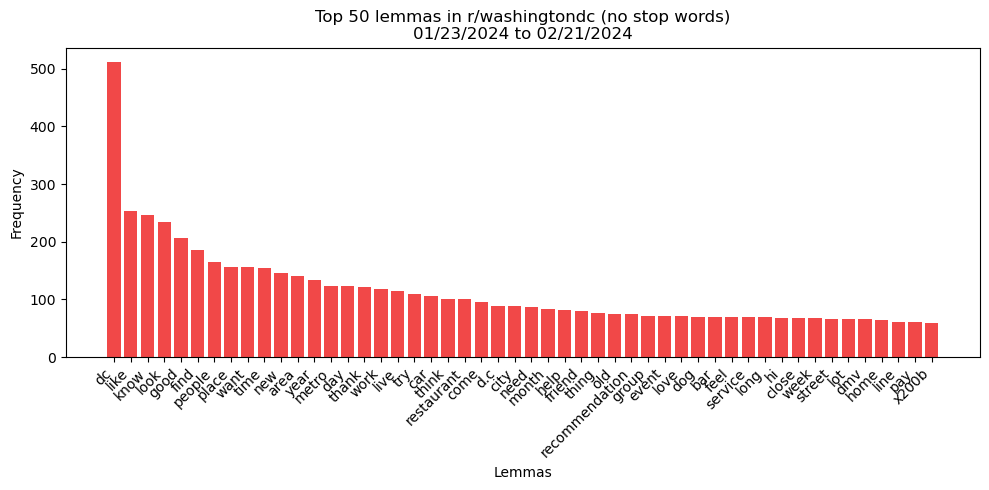

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_lem = OrderedDict(
    FreqDist(df_nlp[df_nlp['text_comb_lemmas_no_sw'].apply(lambda x: len(x) > 0)]['text_comb_lemmas_no_sw'].explode()).most_common(50)
    )

tokens = list(top_50_lem.keys())
freq = list(top_50_lem.values())
ax.bar(x=tokens, height=freq, color='#f14848')
ax.set_xlabel('Lemmas', size=10)
ax.set_ylabel('Frequency', size=10)
ax.set_title(f'Top 50 lemmas in r/{subreddit} (no stop words)\n{oldest} to {newest}')
ax.set_xticklabels(tokens, rotation=45, ha='right')
fig.set_facecolor('white')
plt.tight_layout()
# plt.savefig('./images/top_50_lemmas_no_sw2.png', dpi=500)
plt.show()

### Word Clouds

In [33]:
wc = WordCloud(
    # max_words=500, 
    # random_state=seed, 
    # font_path="./font/NotoSans-Regular.ttf", 
    colormap='Blues',
    # background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    background_color="black", mode="RGBA",
    width=1500,
    height=1000,
    )

In [34]:
fd_tokens = FreqDist(df_nlp['text_comb_tokens_no_sw'].explode())

In [35]:
fd_lemmas = FreqDist(df_nlp['text_comb_lemmas_no_sw'].explode())

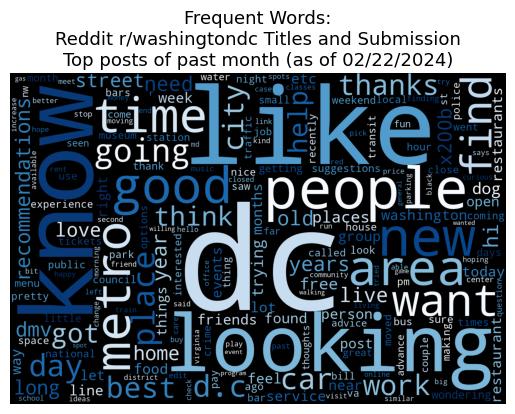

In [36]:
wc.generate_from_frequencies(fd_tokens)
plt.imshow(wc)
plt.axis("off")
plt.title(f'Frequent Words:\nReddit r/{subreddit} Titles and Submission\n{sort.capitalize()} posts of past {time_filter} (as of {date_retrieved})', fontsize=13)
# plt.savefig('./images/word_cloud_tokens_text_comb2.png', dpi=500)
plt.show()

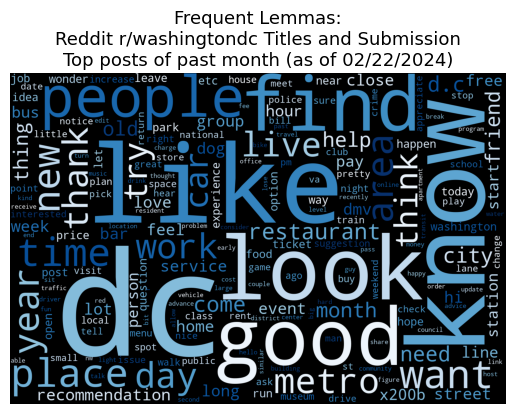

In [37]:
wc.generate_from_frequencies(fd_lemmas)
plt.imshow(wc)
plt.axis("off")
plt.title(f'Frequent Lemmas:\nReddit r/{subreddit} Titles and Submission\n{sort.capitalize()} posts of past {time_filter} (as of {date_retrieved})', fontsize=13)
# plt.savefig('./images/word_cloud_lemmas_text_comb2.png', dpi=500)
plt.show()

## Comments

In [38]:
# Check if any comments aren't actually comments

for i in range(264):
    row = df.iloc[i]['comments']
    types = set([type(x) for x in row])
    if len(types) > 1:
        print(i)

4
26
51


In [39]:
# This "comment" is a "MoreComments" object. It contains more comments that can be called using x._comments

type(df.iloc[3]['comments'][-1])

praw.models.reddit.comment.Comment

In [40]:
type(df.iloc[3]['comments'][-2])

praw.models.reddit.comment.Comment

There's probably a better way, but for now I'm just going to drop anything that's not a comment type.

In [41]:
# I can pull data like comment body and author name from the praw comment object.

display(df['comments'].apply(lambda x: [top_level_comment.body for top_level_comment in x if type(top_level_comment) == praw.models.reddit.comment.Comment]))

display(df['comments'].apply(lambda x: [top_level_comment.author for top_level_comment in x if type(top_level_comment) == praw.models.reddit.comment.Comment]))

# Lots of GIFs in these comments that I should remove

0      [Let’s hope this becomes the norm. Have their ...
1      [Good for you for taking action!  It can be so...
2      [Interested to see how that stainless steel ha...
3      [Laugh at all the people with huge SUVs that c...
4      [I thought we were clocking the tiger print co...
                             ...                        
995    [Clothes usually go quick on Buy Nothing., Ple...
996    [Ice skating at the sculpture garden. Maybe ma...
997    [You’re not going to be able to recreate Vegas...
998    [No you just tap your phone on the fare gates ...
999    [The Mall?, Dan's cafe\n\nbut for real, the Ar...
Name: comments, Length: 1000, dtype: object

0      [-myBIGD, mmeeplechase, bludynamo, lowercaseja...
1      [citygirldc, im_alliterate, keyjan, WinterMedi...
2      [BenBradleesLaptop, strangechicken, ToonTitans...
3      [tantan_noodles, erodari, barelyfallible, lh81...
4      [rnngwen, djackieunchaned, fedrats, statically...
                             ...                        
995    [yonkssssssssssssss, MoreCleverUserName, kalli...
996              [facforlife, goddamnitcletus, legalese]
997                                   [EC_dwtn, rhefter]
998                                              [lh819]
999    [20CAS17, hooahguy, keyjan, Kind_Poet_3260, ma...
Name: comments, Length: 1000, dtype: object

In [48]:
# New df. Exploding the comments so each comment is its own row.
# This is only showing top-level comments at this point

df_comments_nlp = df[['id', 'title', 'datetime', 'comments']]
df_comments_nlp['post_text_comb'] = df_nlp['text_comb']
df_comments_nlp['comments'] = df_comments_nlp['comments'].apply(list)
df_comments_nlp = df_comments_nlp.explode('comments')
df_comments_nlp.columns = ['post_id', 'post_title', 'post_datetime', 'comment_object', 'post_text_comb']
df_comments_nlp = df_comments_nlp[['post_id', 'post_title', 'post_datetime', 'post_text_comb', 'comment_object']]
df_comments_nlp = df_comments_nlp.reset_index().drop(columns='index')
df_comments_nlp = df_comments_nlp[df_comments_nlp['comment_object'].apply(lambda x: type(x) == praw.models.reddit.comment.Comment)]
df_comments_nlp.head()

C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\4227310492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_nlp['post_text_comb'] = df_nlp['text_comb']
C:\Users\zshoo\AppData\Local\Temp\ipykernel_26824\4227310492.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_nlp['comments'] = df_comments_nlp['comments'].apply(list)


,post_id,post_title,post_datetime,post_text_comb,comment_object
0,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvm5ac
1,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvo2bd
2,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvum07
3,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvumye
4,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjws7m8


In [49]:
df_comments_nlp['comment_object'].info()

<class 'pandas.core.series.Series'>
Int64Index: 12611 entries, 0 to 12667
Series name: comment_object
Non-Null Count  Dtype 
--------------  ----- 
12611 non-null  object
dtypes: object(1)
memory usage: 197.0+ KB


In [50]:
df_comments_nlp.isna().sum()

post_id           0
post_title        0
post_datetime     0
post_text_comb    0
comment_object    0
dtype: int64

In [51]:
df_comments_nlp = df_comments_nlp.dropna(subset=['comment_object'])

In [52]:
# New column for comment text

df_comments_nlp['comment'] = df_comments_nlp['comment_object'].apply(lambda x: x.body)

In [53]:
df_comments_nlp['comment'] = df_comments_nlp['comment'].apply(clean_string)

### Duplicates and useless comments

In [54]:
df_comments_nlp['comment'].value_counts()

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                132
                                                                                                                                                                                                                                                                                                                                                                                                           

In [55]:
# Drop deleted and removed comments

df_comments_nlp = df_comments_nlp[df_comments_nlp['comment'] != '[deleted]']
df_comments_nlp = df_comments_nlp[df_comments_nlp['comment'] != '[removed]']

In [56]:
# Drop comments that are gifs

df_comments_nlp = \
    df_comments_nlp[~df_comments_nlp['comment'].apply(lambda x: '![gif]' in x)]

In [57]:
# Drop blank and single character comments

df_comments_nlp = df_comments_nlp[~df_comments_nlp['comment'].apply(lambda x: len(x) in range(0,2))]

In [58]:
# Add a username column to aid in checking duplicates.

df_comments_nlp['user'] = df_comments_nlp['comment_object'].apply(lambda x: x.author.name if x.author else 'no_user')

In [59]:
# Drop posts by AutoModerator, which is a moderator bot

df_comments_nlp = df_comments_nlp[df_comments_nlp['user'] != 'AutoModerator']

In [60]:
# Some duplicate comments may remain, but they are not by the same user so I will view them as unique
# But I will drop duplicates of the same comment, user, and post_id

display(df_comments_nlp[df_comments_nlp.duplicated(subset=['comment'])])

display(df_comments_nlp[df_comments_nlp.duplicated(subset=['comment', 'user', 'post_id'], keep=False)])

,post_id,post_title,post_datetime,post_text_comb,comment_object,comment,user
126,19dyrkt,My first Cyber Truck sighting in DC!,2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,kjd863i,looks like shit,WienerBarf
143,19dyrkt,My first Cyber Truck sighting in DC!,2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,kj9oqob,looks like shit,2711383
236,19dyrkt,My first Cyber Truck sighting in DC!,2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,kjlkwih,does anyone feel cybertrucks are soviet brutal...,Knocksveal
263,1ajnjbk,"DC implements this, what do you do?",2024-02-05 13:24:10,"dc implements this, what do you do?. i am up f...",kp2hgdn,celebrate.,peanutbutterboyo
280,1ajnjbk,"DC implements this, what do you do?",2024-02-05 13:24:10,"dc implements this, what do you do?. i am up f...",kp4gnf4,celebrate,TheSpanishMystic
...,...,...,...,...,...,...,...
12508,1ai47ah,Fine dining restaurant in DC,2024-02-03 14:37:22,fine dining restaurant in dc. some recommendat...,kos04tb,pineapple & pearls,ButtonDelicious
12514,1ai47ah,Fine dining restaurant in DC,2024-02-03 14:37:22,fine dining restaurant in dc. some recommendat...,kosoegk,elizabeth's gone raw,SeveralTailor
12523,1ai47ah,Fine dining restaurant in DC,2024-02-03 14:37:22,fine dining restaurant in dc. some recommendat...,kotolzj,nobu is always a great bet. wide range of deli...,sports2344
12525,1ai47ah,Fine dining restaurant in DC,2024-02-03 14:37:22,fine dining restaurant in dc. some recommendat...,kotw0iv,mita,ephemeralarteries


,post_id,post_title,post_datetime,post_text_comb,comment_object,comment,user
235,19dyrkt,My first Cyber Truck sighting in DC!,2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,kjlkvqu,does anyone feel cybertrucks are soviet brutal...,Knocksveal
236,19dyrkt,My first Cyber Truck sighting in DC!,2024-01-23 15:56:42,my first cyber truck sighting in dc!. kinda co...,kjlkwih,does anyone feel cybertrucks are soviet brutal...,Knocksveal
707,19er4ul,D.C. Ranked #3 in Walkability By Condé Nast,2024-01-24 15:59:33,d.c. ranked #3 in walkability by cond nast. dc...,kjkf8k0,la being in top10 is all you need to know abou...,Illustrious_Lands
708,19er4ul,D.C. Ranked #3 in Walkability By Condé Nast,2024-01-24 15:59:33,d.c. ranked #3 in walkability by cond nast. dc...,kjkf9aq,la being in top10 is all you need to know abou...,Illustrious_Lands
709,19er4ul,D.C. Ranked #3 in Walkability By Condé Nast,2024-01-24 15:59:33,d.c. ranked #3 in walkability by cond nast. dc...,kjkfaoe,la being in top10 is all you need to know abou...,Illustrious_Lands
1800,1ahzynl,[@ericFingrhut] “Part of the plan for parking ...,2024-02-03 11:29:58,"[@ericfingrhut] ""part of the plan for parking ...",kosxcnp,they clearly haven't thought about this at all,Nblearchangel
1801,1ahzynl,[@ericFingrhut] “Part of the plan for parking ...,2024-02-03 11:29:58,"[@ericfingrhut] ""part of the plan for parking ...",kosxf11,they clearly haven't thought about this at all,Nblearchangel
1851,1ahcfhl,“Initiative 82 Fee” 😂😂 what,2024-02-02 14:48:30,"""initiative 82 fee"" what.",kood42o,never heard of this place. huh?,Mammoth_Exam1354
1854,1ahcfhl,“Initiative 82 Fee” 😂😂 what,2024-02-02 14:48:30,"""initiative 82 fee"" what.",kood3qj,never heard of this place. huh?,Mammoth_Exam1354
4449,19ernt1,Are the metro floors being greased? WTH!!,2024-01-24 16:20:53,are the metro floors being greased? wth!!. i g...,kjetvyg,literally just experienced the same thing at t...,B4rkingFr0g


In [61]:
df_comments_nlp.drop_duplicates(subset=['comment', 'user', 'post_id'], inplace=True)

In [71]:
df_comments_nlp.head()

,post_id,post_title,post_datetime,post_text_comb,comment_object,comment,user
0,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvm5ac,let's hope this becomes the norm. have their p...,-myBIGD
1,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvo2bd,2 amy's is seriously just the absolute best. s...,mmeeplechase
2,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvum07,"oftentimes it's not what you say, but how you ...",bludynamo
3,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjvumye,all fine and good but which amy wrote this though,lowercasejames
4,1acoj5j,I respect this from 2 Amys over by Cathedral H...,2024-01-27 18:43:22,i respect this from 2 amys over by cathedral h...,kjws7m8,"dear restaurant owners, this is what diners want.",LawsMan


In [68]:
# Maybe:
# 1. Take the comment column from here, append post_text_comb to the front.
# 2. Combine into a string.
# 3. Clean, make spacy object, tokenize, lemmatize.
# 4. Add the result back to df_nlp.
# 5. Run freqdist and wordcloud on it

df_comments_nlp.groupby(['post_id', 'post_title', 'post_datetime', 'post_text_comb'])['comment'].agg(list).reset_index()

,post_id,post_title,post_datetime,post_text_comb,comment
0,19dhc9r,I’m sure it’s not just D.C.,2024-01-23 00:45:47,i'm sure it's not just d.c.. i order grocery d...,"[using their mama's, sis's, whatever info to m..."
1,19dl17t,Terrible Tuesday!,2024-01-23 05:00:14,terrible tuesday!. what's grinding your gears ...,[woke up. it's still dark so i think still som...
2,19dmq5z,When are garbage trucks returning to alley pic...,2024-01-23 06:52:36,when are garbage trucks returning to alley pic...,[this appears to be a private company situatio...
3,19do4zy,Winter date ideas,2024-01-23 08:13:41,winter date ideas. hi i'm looking for some mid...,[ice skating at the sculpture garden. maybe ma...
4,19doj7w,In search of MMA gyms,2024-01-23 08:34:29,"in search of mma gyms. hi everyone, i will be ...","[in dc proper, beta academy is fantastic, they..."
...,...,...,...,...,...
933,1awsrse,Hit and run - construction company?,2024-02-21 19:44:30,hit and run - construction company?. this car ...,"[man, i hope reddit comes through for ya, wher..."
934,1awt0rq,Caruso’s Grocery Cap Hill vs Pike and Rose (No...,2024-02-21 19:55:37,caruso's grocery cap hill vs pike and rose (no...,[i have been tk both several times. the capito...
935,1awtwcd,Question about FMLA,2024-02-21 20:35:38,question about fmla. my mental health has real...,[if you spend a majority of your time working ...
936,1awuxaw,What happened to The Lucky Bar?,2024-02-21 21:23:15,what happened to the lucky bar?. i was plannin...,[lucky closed like 5 years ago - it said for r...


### Tokenizing Comments

In [ ]:
# Spacy object of each comment